In [ ]:
import re
from typing import Set, cast

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

from utils import ROOTDIR

In [2]:
FILE_PATH = ROOTDIR / "data" / "train_data.csv"

In [3]:
pl.scan_csv(FILE_PATH, truncate_ragged_lines=True).head(5).collect()

id,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,…,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type
i64,i64,i64,str,str,f64,i64,i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,str
3054,36230,443,"""tcp""","""ssl""",10.644097,15,10,7,5,1.409232,0.939488,2.34872,0.666667,488,32,40,316,20,40,2,2,1,4,4,23,0,0,0,0,0.0,1408.0,5465.0,364.333333,570.83431,0.0,1364.0,…,760292.649269,2.6598e6,48.875809,9.9978e6,1.0640e7,1.1822e6,3.3080e6,1.907349,9.9977e6,1.0708e7,446147.501469,2.0353e6,888.097874,7.5,5.0,2732.5,1994.0,0.0,0.0,0.0,0.0,0.0,0.0,64044.952393,645756.006241,709800.958633,354900.479317,411331.830867,9.9977e6,9.9977e6,9.9977e6,9.9977e6,0.0,64240,26544,501,"""ARP_poisioning"""
3576,57920,443,"""tcp""","""ssl""",1.250508,13,12,3,9,10.395777,9.596101,19.991878,0.923077,400,20,40,392,32,40,2,2,2,3,7,22,0,0,0,0,0.0,517.0,840.0,64.615385,149.358929,0.0,1408.0,…,104403.158,111494.7254,43.869019,320106.9832,1.0319e6,93808.26083,132016.2263,43.869019,240163.0878,1.2528e6,52201.57901,92261.77425,5706.481655,13.0,12.0,840.0,6296.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2528e6,1.2528e6,1.2528e6,1.2528e6,0.0,0.0,0.0,0.0,0.0,0.0,64240,26847,0,"""Thing_Speak"""
74179,62897,21,"""tcp""","""-""",0.000002,1,1,1,0,524288.0,524288.0,1.048576e6,1.0,20,20,20,20,20,20,0,1,1,0,0,1,0,0,0,0,120.0,120.0,120.0,120.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.907349,1.907349,1.907349,1.907349,0.0,6.291456e7,1.0,1.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.907349,1.907349,1.907349,1.907349,0.0,0.0,0.0,0.0,0.0,0.0,64,0,64,"""DOS_SYN_Hping"""
1011,50078,49186,"""udp""","""-""",0.0,1,0,1,0,0.0,0.0,0.0,0.0,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,40.0,40.0,40.0,40.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,"""NMAP_UDP_SCAN"""
74372,27538,21,"""tcp""","""-""",0.000002,1,1,1,0,466033.777778,466033.777778,932067.555556,1.0,20,20,20,20,20,20,0,1,1,0,0,1,0,0,0,0,120.0,120.0,120.0,120.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.145767,2.145767,2.145767,2.145767,0.0,5.5924e7,1.0,1.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.145767,2.145767,2.145767,2.145767,0.0,0.0,0.0,0.0,0.0,0.0,64,0,64,"""DOS_SYN_Hping"""


In [4]:
data = pl.scan_csv(FILE_PATH, truncate_ragged_lines=True).collect()

In [5]:
data.columns

['id',
 'id.orig_p',
 'id.resp_p',
 'proto',
 'service',
 'flow_duration',
 'fwd_pkts_tot',
 'bwd_pkts_tot',
 'fwd_data_pkts_tot',
 'bwd_data_pkts_tot',
 'fwd_pkts_per_sec',
 'bwd_pkts_per_sec',
 'flow_pkts_per_sec',
 'down_up_ratio',
 'fwd_header_size_tot',
 'fwd_header_size_min',
 'fwd_header_size_max',
 'bwd_header_size_tot',
 'bwd_header_size_min',
 'bwd_header_size_max',
 'flow_FIN_flag_count',
 'flow_SYN_flag_count',
 'flow_RST_flag_count',
 'fwd_PSH_flag_count',
 'bwd_PSH_flag_count',
 'flow_ACK_flag_count',
 'fwd_URG_flag_count',
 'bwd_URG_flag_count',
 'flow_CWR_flag_count',
 'flow_ECE_flag_count',
 'fwd_pkts_payload.min',
 'fwd_pkts_payload.max',
 'fwd_pkts_payload.tot',
 'fwd_pkts_payload.avg',
 'fwd_pkts_payload.std',
 'bwd_pkts_payload.min',
 'bwd_pkts_payload.max',
 'bwd_pkts_payload.tot',
 'bwd_pkts_payload.avg',
 'bwd_pkts_payload.std',
 'flow_pkts_payload.min',
 'flow_pkts_payload.max',
 'flow_pkts_payload.tot',
 'flow_pkts_payload.avg',
 'flow_pkts_payload.std',
 'fwd

In [6]:
[column for column, nulls in data.null_count().to_dict().items() if nulls.item() > 0]

[]

---

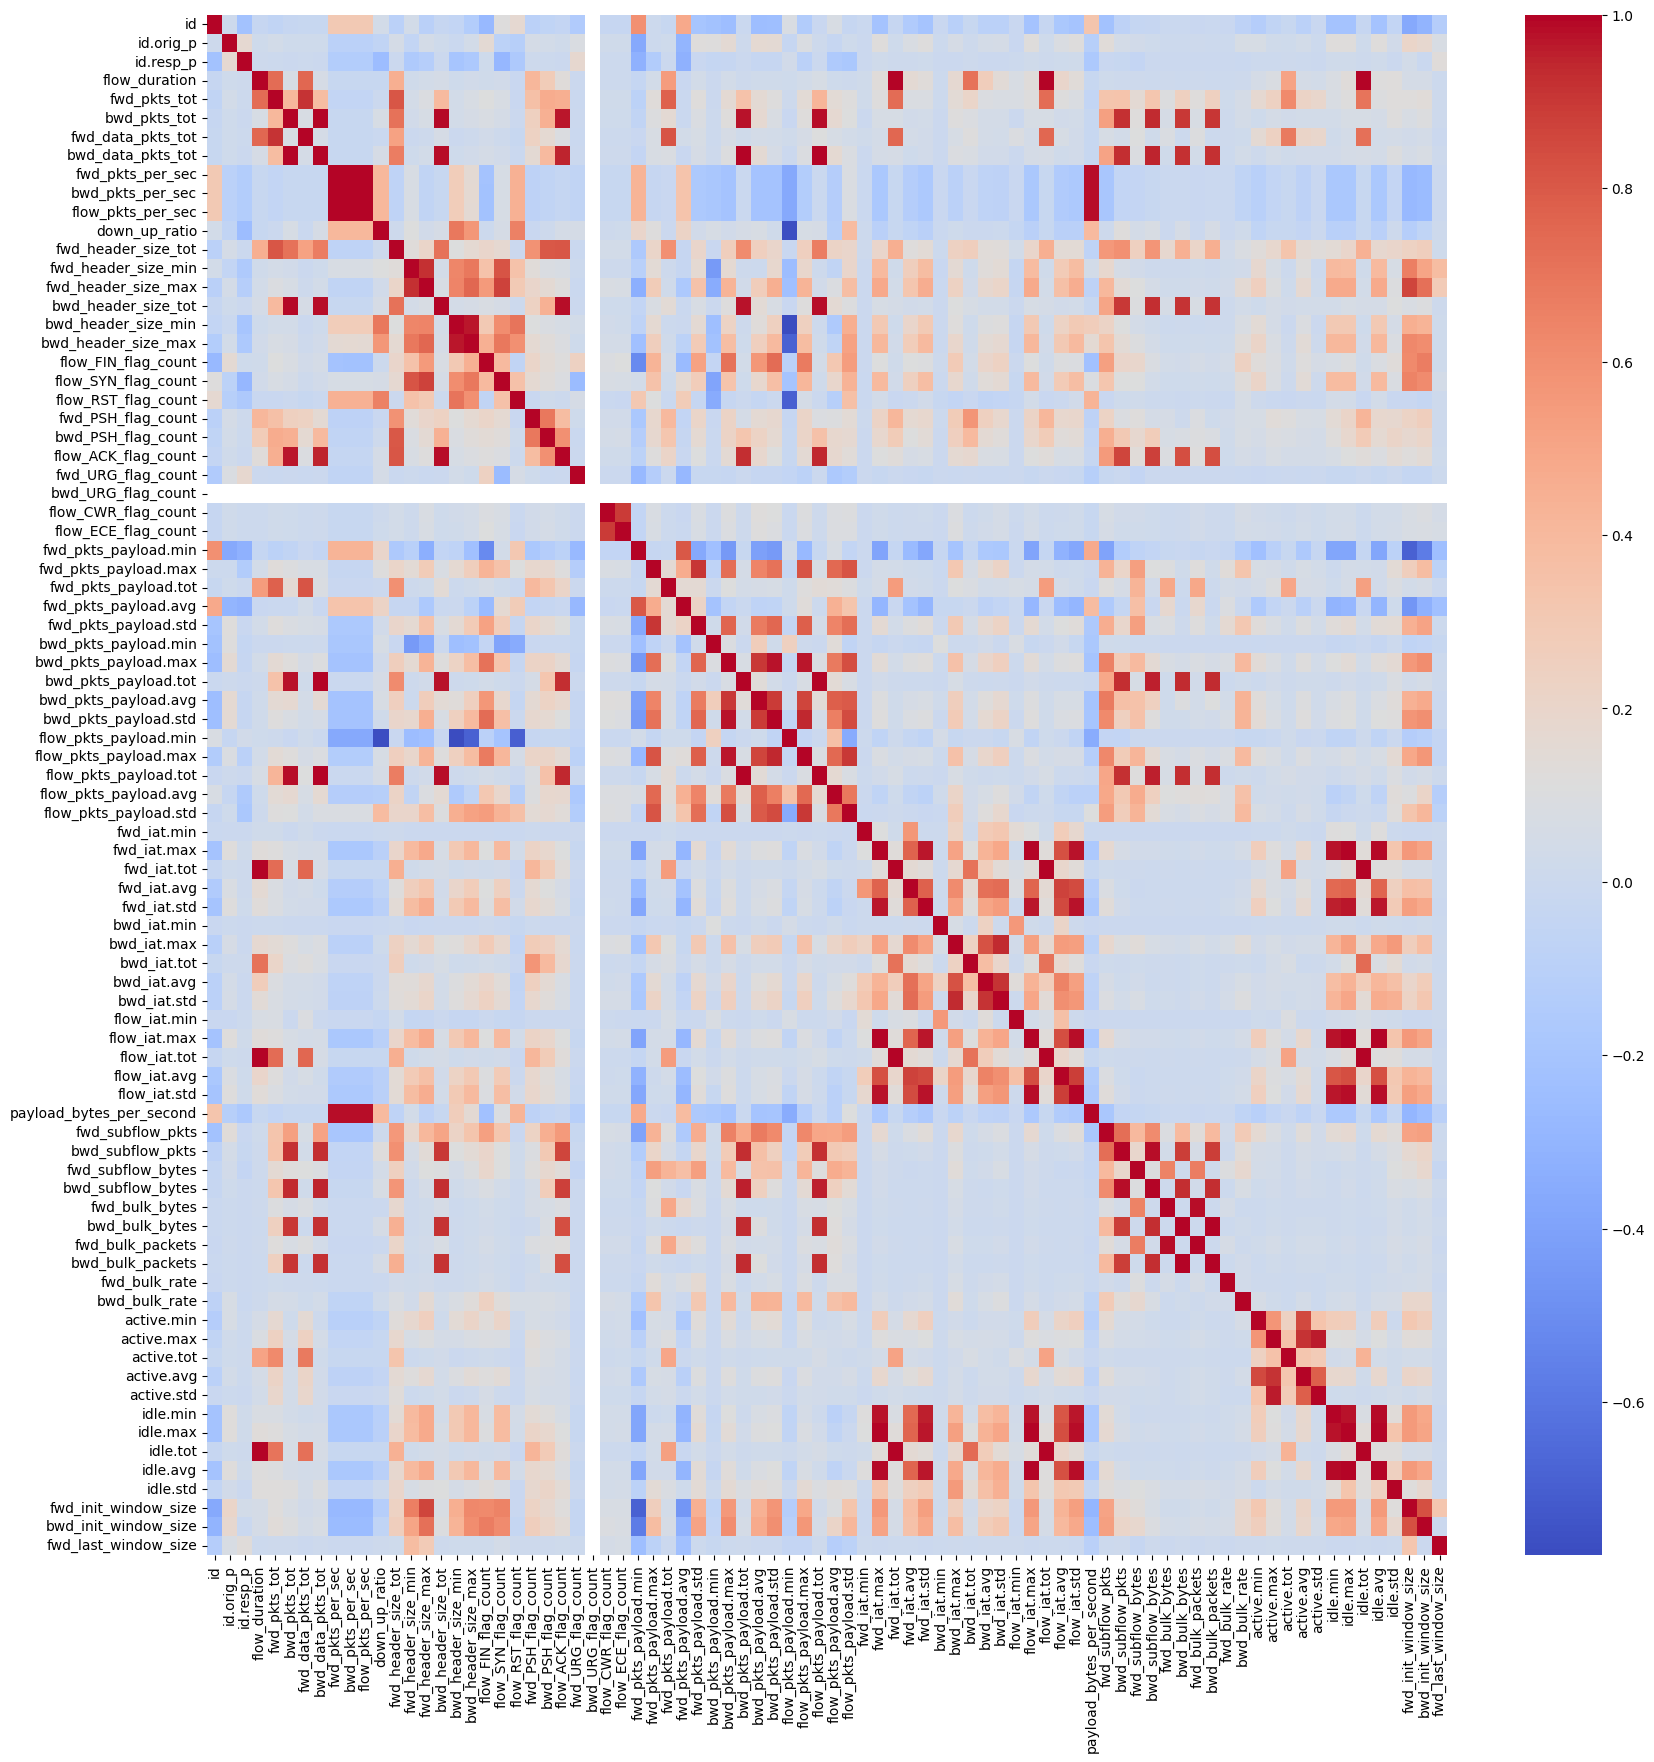

In [11]:
# type: ignore

plt.figure(figsize=(20, 20))
sns.heatmap(
    data.select(
        [
            column
            for column, dtype in zip(data.columns, data.dtypes)
            if dtype in [pl.Int32, pl.Int64, pl.Float32, pl.Float64]
        ]
    )
    .to_pandas()
    .corr(),
    annot=False,
    cmap="coolwarm",
)
plt.show()

In [ ]:
target_columns = "Attack_type"

In [ ]:
corr_matrix = (
    data.select(
        [
            column
            for column, dtype in zip(data.columns, data.dtypes)
            if dtype in [pl.Int32, pl.Int64, pl.Float32, pl.Float64]
        ]
    )
    .to_pandas()
    .corr()
    .abs()
)

df = data.drop(
    [
        column
        for column in data.columns
        if re.search(r"^id$|^id[._]|[._]id$", column, re.IGNORECASE)
    ]
)

highly_correlated: Set[str] = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if cast(float, corr_matrix.iat[i, j]) > 0.95:
            colname = corr_matrix.columns[j]
            highly_correlated.add(colname)

display(f"highly-correlated columns: {list(highly_correlated)}")